In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
import matplotlib.colors as colors
import scipy as sp
import scipy.stats as stats
import scipy.ndimage
from sklearn.utils import resample as bootstrap
from scipy.optimize import curve_fit
from scipy.interpolate import make_interp_spline, BSpline
from scipy.ndimage.filters import gaussian_filter1d
import matplotlib.gridspec as gridspec
import reliability
from reliability.Distributions import Weibull_Distribution

from reliability.Distributions import Gamma_Distribution

import matplotlib.patches as patches
from labellines import labelLine, labelLines

%matplotlib inline

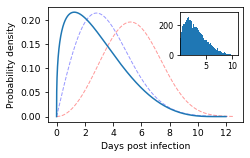

In [2]:
#This block defines the distributions of latent and pre-patent periods and the random draws from their difference
dist_trans = Weibull_Distribution(alpha=4, beta=2)  # this created the distribution object
dist_sympt = Weibull_Distribution(alpha=6, beta=3)

sims=10000

data_t = dist_trans.random_samples(sims*2, seed=2)# x2 because need to go through and cut out the negatives
data_s = dist_sympt.random_samples(sims*2, seed=3)
z=0
zam=0
zoo=[]

while zam < sims:               #This loop eliminates draws whereby infectiousness trails symptoms
    
    new_dis=data_s[z]-data_t[z]
    if new_dis>=0:
        zoo.append(new_dis)
        zam=zam+1
    z=z+1

fig, (axZ) = plt.subplots(figsize=[3.5, 2.2])

aa,bb,cc,dd = stats.beta.fit(zoo,floc=0)     #floc=0 ensures that there are no negative values in the fitted pdf

xmin, xmax = 0, 12 
lnspc2 = np.linspace(xmin, xmax, len(zoo))

best_fit_line2 = stats.beta.pdf(lnspc2,aa,bb,cc,dd)

dis=dist_trans.PDF(color='blue', linestyle='--', linewidth=1, alpha=0.4)
sym=dist_sympt.PDF(color='red', linestyle='--',linewidth=1, alpha=0.4)
axZ.plot(lnspc2, best_fit_line2)

axZ.set_title("",fontsize=0)


axZ.set_xlabel("Days post infection",fontsize=9.2)
axZ.set_ylabel("Probability density",fontsize=9.2)
axZ.tick_params(labelsize=9.2)


z_data = np.random.choice(lnspc2, size=10000, p=best_fit_line2/np.sum(best_fit_line2))

axins = inset_axes(axZ, width=0.8, height=0.6)
axins.hist(z_data,bins=100)
axins.tick_params(labelsize=8)
axins.margins(x=0)
        
#fig.savefig('covid_distributions.png', bbox_inches='tight', dpi = 600)    


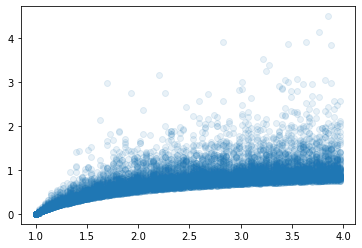

In [3]:
#This block calculates Q* using the 10,000 random draws for the time difference between infectiousness and symptoms
index_set2a = range(100)
index_set2b = range(100)
track_Re = []
track_Q = []
track_fret = []
recovery=12
a=0

for i in index_set2a[0:]:
    Re=1.001+.03*i
    a=a+1
    np.random.seed(a)
    rep_data = np.random.choice(lnspc2, size=100, p=best_fit_line2/np.sum(best_fit_line2))
    
    for j in index_set2b[0:]:
        fret = rep_data[j]
        QQ_sim = (1 - (1/Re)) * (1/(1-(fret/recovery)))
        #* np.exp(((np.log(.5)*np.log((recovery-1)/recovery))/np.log(2))*fret)
        track_Re.append(Re)
        track_Q.append(QQ_sim)
        track_fret.append(fret)

plt.scatter(track_Re,track_Q,alpha=.1)  
    
    

In [4]:
print(min(rep_data),max(rep_data))

0.0636063606360636 8.501650165016502


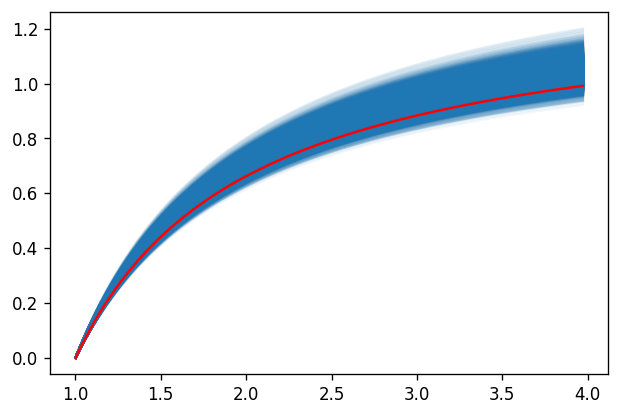

In [11]:
#Bootstrapping
def f(x,track_fret,recovery):
    return (1-(1/x)) * 12/(12-track_fret)#(1/(1-(track_fret/recovery)))
    
#real data
x = np.linspace(np.min(track_Re), np.max(track_Re), 100)
y = (1-(1/x))  * 12/(12-rep_data)#* (1/(1-(rep_data/recovery)))

#confidence intervals
nboot = 10000
bspreds = np.zeros((nboot, y.size))

for i in range(nboot):
    xb,yb = bootstrap(x,y)
    params, cov = curve_fit(f,xb,yb, bounds = ((0, 0),(np.inf, np.inf)))
    bspreds[i] = f(x,*params)
    
params, cov = curve_fit(f,x,y, bounds = ((0, 0),(np.inf, np.inf)))
fig, ax = plt.subplots(dpi = 120)
plt.plot(x, bspreds.T, color = 'C0', alpha = 0.05)
plt.plot(x,f(x,*params), color = 'C0')
plt.plot(x, f(x, np.mean(z_data), 12), color = 'red')

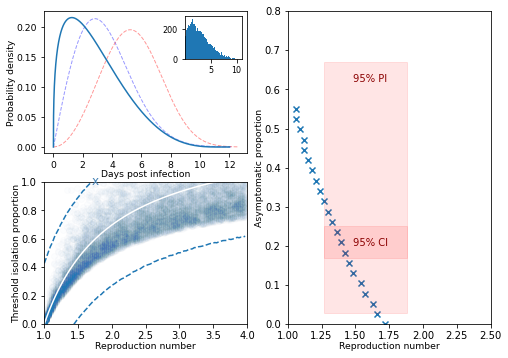

In [12]:
fig = plt.figure(figsize=(8, 6))
ax1= fig.add_subplot(2,2,1)



data_t = dist_trans.random_samples(sims*2, seed=2)# x2 because need to go through and cut out the negatives
data_s = dist_sympt.random_samples(sims*2, seed=3)
z=0
zam=0
zoo=[]

while zam < sims:
    new_dis=data_s[z]-data_t[z]
    if new_dis>=0:
        zoo.append(new_dis)
        zam=zam+1
    z=z+1

#fig, (axZ) = plt.subplots(figsize=[3.5, 2.2])

aa,bb,cc,dd = stats.beta.fit(zoo,floc=0)

xmin, xmax = 0, 12 
lnspc2 = np.linspace(xmin, xmax, len(zoo))

best_fit_line2 = stats.beta.pdf(lnspc2,aa,bb,cc,dd)

dis=dist_trans.PDF(color='blue', linestyle='--', linewidth=1, alpha=0.4)
sym=dist_sympt.PDF(color='red', linestyle='--',linewidth=1, alpha=0.4)
ax1.plot(lnspc2, best_fit_line2)

ax1.set_title("",fontsize=0)


ax1.set_xlabel("Days post infection",fontsize=9.2)
ax1.set_ylabel("Probability density",fontsize=9.2)
ax1.tick_params(labelsize=9.2)
#plt.tight_layout()
ax1.xaxis.labelpad = 0.5
ax1.yaxis.labelpad = 0.5

z_data = np.random.choice(lnspc2, size=10000, p=best_fit_line2/np.sum(best_fit_line2))

axins = inset_axes(ax1, width=0.8, height=0.6)
axins.hist(z_data,bins=100)
axins.tick_params(labelsize=8)
axins.margins(x=0)

ax5a= fig.add_subplot(2,2,3)
ax5b= fig.add_subplot(1,2,2)




ypred = f(x,*params)
noise = np.std(y - ypred)
predictions = np.array([np.random.normal(ypred,noise) for j in range(100000)])

u,l = np.quantile(predictions, [0.05, 0.95], axis = 0)

ax5a.scatter(track_Re,track_Q,alpha=.01)
ax5a.plot(x, ypred, color = 'white')
ax5a.plot(x, u, 'C0--')
ax5a.plot(x, l, 'C0--')
ax5a.set_xlim(xmin=1, xmax=4)
ax5a.set_ylim(ymin=0, ymax=1)
ax5a.xaxis.labelpad = 0.5
ax5a.yaxis.labelpad = 0.5
ax5a.set_xlabel("Reproduction number",fontsize=9.2)
ax5a.set_ylabel("Threshold isolation proportion",fontsize=9.2)
ax5a.text(1.7, .98, 'x',color='steelblue', fontsize=12)


Thresh = []

for i in range(22):             #This loop calculates where the upper 95%PI yields Q**>1 for different asymptomatic proportions
    sympt = 1-(i*.025)

    def f(x,track_fret,recovery):
        return (1/sympt) * (1-(1/x)) * 12/(12-track_fret)#* ((recovery-1)/recovery)**-(track_fret)

    y = (1/sympt) * (1-(1/x)) * 12/(12-rep_data)#* ((recovery-1)/recovery)**-(rep_data)
    
    params, cov = curve_fit(f,x,y, bounds = ((0, 0), (np.inf, np.inf)))

    ypred = f(x,*params)
    noise = np.std(y - ypred)
    predictions = np.array([np.random.normal(ypred,noise) for j in range(100000)])

    l,u = np.quantile(predictions, [0.05, 0.95], axis = 0)

    cut = next(i for i,v in enumerate(u) if v > 1)
    Thresh.append(x[cut])
    
    
asy=np.linspace(0,0.55,22)
ax5b.scatter(Thresh,asy,marker='x')
ax5b.set_ylabel("Asymptomatic proportion",fontsize=9.2)
ax5b.set_xlabel("Reproduction number",fontsize=9.2)
ax5b.set_xlim(xmin=1, xmax=2.5)
ax5b.set_ylim(ymin=0, ymax=0.8)
ax5b.xaxis.labelpad = 0.5
ax5b.yaxis.labelpad = 0.5
ax5b.margins(x=1,y=0)
ax5b.add_patch(patches.Rectangle((1.27,.17), .61, .08, color="red", alpha=0.1))
ax5b.add_patch(patches.Rectangle((1.27,.03), .61, .64, color="red", alpha=0.1))
font_dict = {'color':'darkred',
                 'size':10}
ax5b.text(1.48, 0.2,'95% CI', fontdict=font_dict)
ax5b.text(1.48, 0.62,'95% PI', fontdict=font_dict)
fig.savefig('Quarantine_threshold.png', bbox_inches='tight', dpi = 600)
